<a href="https://colab.research.google.com/github/MPrazzoli/financial_markets_academy/blob/master/_8_jupyter_notebooks/ipynb_notebook/GAN_analysis/tech_solar_GAN_analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
from utils import *
import math
import requests
import datetime
import time

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data as pdr
import yfinance as yf
from yahoo_fin import stock_info as si
from pandas import ExcelWriter

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import xgboost as xgb

import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn

### Importo dai csv OHLC e volume. Time period Ago 2019 - Mar 2021

In [2]:
open_df = pd.read_csv('/content/drive/MyDrive/Data/20210322/open', index_col='date')
high_df = pd.read_csv('/content/drive/MyDrive/Data/20210322/high', index_col='date')
low_df = pd.read_csv('/content/drive/MyDrive/Data/20210322/low', index_col='date')
adjclose_df = pd.read_csv('/content/drive/MyDrive/Data/20210322/adjclose', index_col='date')
volume_df = pd.read_csv('/content/drive/MyDrive/Data/20210322/volume', index_col='date')

In [3]:
adjclose_df.head()

,A,AA,AACG,AAIC,AAL,AAMC,AAME,AAOI,AAON,AAP,AAPL,AAU,AAWW,AAXN,ABB,ABBV,ABC,ABCB,ABEO,ABEV,ABG,ABIO,ABM,ABMD,ABR-PA,ABR-PB,ABR-PC,ABR,ABT,ABTX,ABUS,AC,ACA,ACAD,ACAM,ACB,ACBI,ACC,ACCO,ACER,...,YNDX,YORW,YPF,YRCW,YRD,YTEN,YTRA,YUM,YUMC,YVR,YY,Z,ZAGG,ZBH,ZBRA,ZDGE,ZEAL,ZEN,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNH,ZOM,ZS,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-29,69.507103,23.120001,2.60,6.173435,30.420858,10.50,2.48,9.28,50.196346,151.483002,51.619480,0.76,45.020000,68.480003,17.742832,61.114616,84.908302,38.025436,3.00,5.105173,94.519997,6.61,40.410297,275.929993,23.124428,23.041702,23.445513,10.500124,86.479134,33.688457,1.77,36.521278,35.409374,24.07,9.77,74.519997,18.250000,43.623848,7.721152,2.70,...,39.340000,34.916077,16.940001,3.18,11.22,33.200001,4.52,111.064354,44.960625,1.64,63.978214,49.400002,6.42,133.020050,189.419998,1.70,22.920000,92.830002,11.992391,49.160000,48.180000,42.383152,5.99,8.77,1.29,35.900002,96.470001,6.41,33.110001,0.255,85.570000,2.82,19.724510,114.744720,25.590000,15.19,3.81,24.160000,10.79,8.29
2019-07-30,69.289803,23.040001,2.60,6.191918,30.391171,9.55,2.36,9.48,51.117470,150.255630,51.397919,0.76,46.599998,69.639999,17.982212,61.114616,86.358635,38.722973,2.98,5.029541,92.970001,6.88,40.894249,279.230011,23.381266,23.072792,23.411728,10.586121,86.244743,33.333218,1.90,36.797657,36.946327,25.00,9.77,75.000000,18.459999,43.484032,7.702228,2.87,...,38.869999,35.121174,16.700001,3.18,11.15,34.000000,4.55,110.227242,43.545403,1.60,63.661297,48.900002,6.60,135.136017,218.199997,1.87,22.559999,93.120003,12.150840,48.770000,49.259998,43.171009,6.58,8.80,1.28,33.470001,95.489998,6.44,32.570000,0.262,84.680000,2.82,19.764078,114.983047,24.969999,15.50,3.87,23.190001,10.82,8.39
2019-07-31,68.558876,22.490000,2.63,6.081018,30.193247,9.46,2.35,10.01,50.315197,149.107422,52.446659,0.73,45.650002,70.220001,18.001360,60.605186,84.830429,38.529217,2.59,4.982271,92.080002,6.85,40.739388,278.559998,23.336985,22.992886,23.368481,10.482924,85.063049,33.116131,1.78,36.886486,37.184307,24.58,9.77,75.000000,18.389999,43.577244,9.254025,2.99,...,39.220001,35.130943,16.450001,3.26,11.19,33.200001,4.59,109.526390,45.029903,1.64,63.572163,49.959999,6.63,133.613327,210.889999,1.61,22.629999,83.559998,12.457829,49.840000,48.169998,42.781830,6.94,9.11,1.26,32.119999,95.510002,6.38,32.380001,0.260,84.269997,2.90,19.437643,114.089317,24.770000,15.01,3.81,22.850000,10.59,8.32
2019-08-01,68.361320,21.330000,2.61,5.923910,29.530205,7.99,2.35,9.93,51.365082,148.424423,51.311756,0.74,34.410000,68.440002,17.694956,59.859211,89.259323,37.376339,2.52,5.001179,91.480003,6.35,39.771477,204.869995,23.319273,22.992886,23.332125,10.534522,84.066910,32.119488,1.72,36.619984,35.528370,28.67,9.77,70.199997,17.870001,43.250999,9.197253,2.72,...,38.250000,35.033276,16.020000,3.01,10.71,32.799999,4.51,113.828796,44.238171,1.65,60.274212,49.700001,6.37,135.956711,204.259995,1.66,22.417000,82.680000,11.932976,49.480000,48.500000,40.759964,6.77,9.33,1.21,32.040001,95.099998,6.39,30.820000,0.260,85.260002,2.76,19.101318,114.893661,22.900000,14.84,3.83,23.410000,10.24,9.21
2019-08-02,67.245178,20.709999,2.52,5.877702,29.144255,10.09,2.35,9.96,46.155281,144.296875,50.226093,0.71,32.750000,69.080002,17.838583,59.449837,88.032867,36.979130,2.42,4.953908,92.160004,6.12,39.384308,200.619995,23.319273,23.072792,23.685913,10.990301,83.812981,31.971474,1.63,36.195549,34.864006,28.73,9.77,75.959999,17.950001,43.633175,9.121556,2.73,...,37.540001,34.896538,15.880000,3.07,10.77,34.799999,4.44,114.227898,44.703312,1.70,59.858253,49.160000,6.03,136.520340,198.929993,1.69,21.950001,80.199997,11.932976,48.939999,47.580002,40.389771,6.49,9.15,1.22,31.490000,93.660004,6.21,30.990000,0.262,83.480003,2.75,18.893589,115.549080,22.750000,14.83,3.84,23.400000,10.16,9.20


### Importo lista dei financials più aggiornati dei ticker da FinViz

In [4]:
ticker_financials_df = pd.read_excel('/content/drive/MyDrive/Data/20210322/ticker_isin_file_financials.xlsx', index_col=0)
ticker_financials_df.head()

,isin,exchange_id,Sector,Industry,Country,P/E,EPS (ttm),Insider Own,Shs Outstand,Shs Float,Market Cap,Income,Sales,Book/sh,P/B,ROA,Target Price,ROE,ROI,Employees,Debt/Eq
ticker,,,,,,,,,,,,,,,,,,,,,
FLWS,US68243Q1067,663,Consumer Cyclical,Specialty Retail,USA,34.57,0.96,0.2610,6.432e+07,24070000,2160000000,64500000,1590000000,6.09,5.46,0.079,35.43,0.163,0.125,4300.0,0.54
TXG,US88025U1097,663,Healthcare,Health Information Services,USA,NaN,-1.35,0.0210,101340000,71960000,19560000000,-134300000,261900000,8.14,22.51,-0.189,157.50,-0.263,-0.068,713.0,0.00
YI,US68247Q1022,663,Healthcare,Health Information Services,China,NaN,-0.91,NaN,82430000,45810000,694400000,-74900000,1070000000,0.91,13.03,-0.246,12.00,-0.765,-0.562,1932.0,0.37
YQ,US81807M1062,663,Consumer Defensive,Education & Training Services,China,NaN,NaN,0.0231,191310000,50120000,3010000000,-,154800000,NaN,NaN,NaN,NaN,NaN,0.227,2613.0,NaN
ATNF,US68236V1044,663,Healthcare,Biotechnology,USA,NaN,-1.00,0.2290,5180000,970000,65970000,-4700000,-,1.36,2.99,-0.388,NaN,-0.707,NaN,2.0,0.37


### Statistiche per settore
Nel Technology abbiamo 631 titoli in 3 mercati e 12 paesi. Hanno un'ottima percentuale di Shs Outstand e Market Cap popolate possiamo pensare di iniziare da qua

In [5]:
ticker_financials_df.groupby('Sector').nunique()

,isin,exchange_id,Industry,Country,P/E,EPS (ttm),Insider Own,Shs Outstand,Shs Float,Market Cap,Income,Sales,Book/sh,P/B,ROA,Target Price,ROE,ROI,Employees,Debt/Eq
Sector,,,,,,,,,,,,,,,,,,,,
Basic Materials,231,3,14,19,120,185,123,228,229,228,196,195,218,186,155,155,171,140,199,116
Communication Services,250,3,7,24,106,207,154,248,239,244,224,223,227,189,170,186,187,183,222,110
Consumer Cyclical,474,3,23,23,219,367,186,461,464,445,420,419,428,342,254,343,352,298,398,207
Consumer Defensive,210,3,12,13,136,176,112,207,204,203,188,194,196,157,130,147,162,158,192,112
Energy,237,3,8,21,64,210,133,231,233,233,219,223,229,160,186,166,198,172,193,118
Financial,784,3,16,25,498,462,242,722,662,733,580,605,634,288,160,444,294,318,578,192
Healthcare,1046,3,11,23,194,548,410,999,991,965,746,604,712,664,647,523,742,552,526,188
Industrials,559,3,25,22,323,416,212,547,540,521,494,498,511,389,270,389,389,299,451,215
Real Estate,211,3,12,6,125,177,93,211,208,199,200,203,200,153,113,171,151,108,148,143


All'interno del Technology vediamo come sono distriibuti per Industry. Nel Solar ci sono tante colonne valorizzate per tutti e 16 i titoli che la compongono (sempre 3 mercati diversi)

In [6]:
ticker_financials_df.loc[ticker_financials_df['Sector'] == 'Technology'].groupby('Industry').nunique()

,isin,exchange_id,Sector,Country,P/E,EPS (ttm),Insider Own,Shs Outstand,Shs Float,Market Cap,Income,Sales,Book/sh,P/B,ROA,Target Price,ROE,ROI,Employees,Debt/Eq
Industry,,,,,,,,,,,,,,,,,,,,
Communication Equipment,65,3,1,6,20,60,46,65,65,65,62,65,64,56,61,47,60,59,63,36
Computer Hardware,27,2,1,7,11,26,19,27,27,27,27,27,26,24,23,19,24,25,27,18
Consumer Electronics,14,3,1,4,7,14,13,14,14,14,14,14,14,14,14,12,14,14,14,12
Electronic Components,36,3,1,9,26,35,30,36,36,35,35,36,36,36,31,27,32,34,36,26
Electronics & Computer Distribution,7,2,1,1,4,7,6,7,7,7,7,7,7,7,5,4,6,7,7,6
Information Technology Services,64,3,1,11,40,62,40,64,64,63,64,60,58,55,54,53,59,58,63,45
Scientific & Technical Instruments,32,2,1,4,19,32,26,32,32,32,32,32,32,31,30,23,31,31,31,18
Semiconductor Equipment & Materials,30,3,1,5,20,29,25,30,30,29,30,30,28,30,30,24,29,28,29,22
Semiconductors,64,3,1,9,41,57,38,64,64,64,63,64,61,61,57,59,58,59,62,38


In [7]:
tech_solar_financials_df = ticker_financials_df.loc[(ticker_financials_df['Sector'] == 'Technology') & (ticker_financials_df['Industry'] == 'Solar')]
tech_solar_financials_df

,isin,exchange_id,Sector,Industry,Country,P/E,EPS (ttm),Insider Own,Shs Outstand,Shs Float,Market Cap,Income,Sales,Book/sh,P/B,ROA,Target Price,ROE,ROI,Employees,Debt/Eq
ticker,,,,,,,,,,,,,,,,,,,,,
ARRY,US04271T1007,663,Technology,Solar,USA,64.22,0.75,0.0040,123640000,99100000,5980000000,95600000,916800000,3.14,15.38,NaN,50.05,NaN,0.145,369.0,0.00
BEEM,US07373B1098,663,Technology,Solar,USA,NaN,-0.77,0.0200,6620000,5880000,472080000,-4300000,4500000,2.25,26.23,-0.437,48.33,-0.558,-0.546,26.0,0.02
CSIQ,CA1366351098,663,Technology,Solar,Canada,17.43,3.48,0.3100,59750000,45050000,3640000000,207800000,3360000000,25.12,2.41,0.037,50.43,0.142,0.057,13478.0,1.84
ENPH,US29355A1079,663,Technology,Solar,USA,158.88,1.28,0.0170,126110000,115210000,25610000000,177700000,719600000,3.30,61.43,0.185,170.75,0.517,0.460,577.0,0.87
FSLR,US3364331070,663,Technology,Solar,USA,50.26,2.09,0.0860,105970000,93310000,11210000000,223200000,3500000000,50.92,2.06,0.031,84.76,0.043,-0.028,6600.0,0.05
ISUN,US4652461066,663,Technology,Solar,USA,NaN,-0.32,NaN,5300000,2970000,137330000,-1700000,18100000,1.35,19.83,-0.091,NaN,-0.298,-0.019,50.0,1.25
JKS,US47759T1007,676,Technology,Solar,China,21.29,3.19,0.0100,44500000,42830000,3070000000,151200000,5450000000,34.34,1.98,0.020,49.35,0.101,0.051,15195.0,2.53
MAXN,SGXZ25336314,663,Technology,Solar,Singapore,NaN,NaN,0.5944,24770000,13590000,1490000000,-,967400000,19.32,2.28,NaN,33.67,NaN,-0.344,5194.0,0.36
SOL,US75971T3014,676,Technology,Solar,USA,NaN,-0.07,NaN,107660000,19890000,1350000000,-10100000,83600000,21.23,1.23,-0.034,9.25,-0.106,-0.011,222.0,0.89


### Nei dataset facciamo il drop dell'ultimo girono che è duplicato

In [11]:
open_df.duplicated()

date
2019-07-29    False
2019-07-30    False
2019-07-31    False
2019-08-01    False
2019-08-02    False
              ...  
2021-03-15    False
2021-03-16    False
2021-03-17    False
2021-03-18    False
2021-03-19     True
Length: 415, dtype: bool

In [12]:
open_df.drop(index='2021-03-19', inplace=True)
high_df.drop(index='2021-03-19', inplace=True)
low_df.drop(index='2021-03-19', inplace=True)
adjclose_df.drop(index='2021-03-19', inplace=True)
volume_df.drop(index='2021-03-19', inplace=True)

In [13]:
if open_df.isnull().values.any():
    print('open shape before: ', open_df.shape)
    open_df.dropna(axis=1, how='any', inplace=True)
    print('open shape after: ', open_df.shape)    
if high_df.isnull().values.any():
    print('high shape before: ', high_df.shape)
    high_df.dropna(axis=1, how='any', inplace=True)
    print('high shape after: ', high_df.shape)  
if low_df.isnull().values.any():
    print('low shape before: ', low_df.shape)
    low_df.dropna(axis=1, how='any', inplace=True)
    print('low shape after: ', low_df.shape)    
if adjclose_df.isnull().values.any():
    print('high shape before: ', adjclose_df.shape)
    adjclose_df.dropna(axis=1, how='any', inplace=True)
    print('high shape after: ', adjclose_df.shape) 
if volume_df.isnull().values.any():
    print('high shape before: ', volume_df.shape)
    volume_df.dropna(axis=1, how='any', inplace=True)
    print('high shape after: ', volume_df.shape)   

open shape before:  (414, 4541)
open shape after:  (414, 4534)
high shape before:  (414, 4541)
high shape after:  (414, 4534)
low shape before:  (414, 4541)
low shape after:  (414, 4534)
high shape before:  (414, 4541)
high shape after:  (414, 4534)
high shape before:  (414, 4541)
high shape after:  (414, 4534)


### Confrontiamo i ticker del df dei financials con quello dei prezzi. Eliminiamo i titoli che non matchano

In [14]:
df_columns = open_df.columns
df_columns

Index(['A', 'AA', 'AACG', 'AAIC', 'AAL', 'AAMC', 'AAME', 'AAOI', 'AAON', 'AAP',
       ...
       'ZS', 'ZSAN', 'ZTO', 'ZTS', 'ZUMZ', 'ZUO', 'ZVO', 'ZYME', 'ZYNE',
       'ZYXI'],
      dtype='object', length=4534)

In [15]:
tech_solar_financials_index = tech_solar_financials_df.index
tech_solar_financials_index

Index(['ARRY', 'BEEM', 'CSIQ', 'ENPH', 'FSLR', 'ISUN', 'JKS', 'MAXN', 'SOL',
       'SEDG', 'SPI', 'NOVA', 'SPWR', 'RUN', 'SUNW', 'VVPR'],
      dtype='object', name='ticker')

In [17]:
unmatch = list(set(tech_solar_financials_index) - set(df_columns))
unmatch

['ISUN', 'MAXN', 'ARRY', 'BEEM']

In [18]:
tech_solar_financials_df.drop(unmatch, inplace=True)
tech_solar_financials_df

,isin,exchange_id,Sector,Industry,Country,P/E,EPS (ttm),Insider Own,Shs Outstand,Shs Float,Market Cap,Income,Sales,Book/sh,P/B,ROA,Target Price,ROE,ROI,Employees,Debt/Eq
ticker,,,,,,,,,,,,,,,,,,,,,
CSIQ,CA1366351098,663,Technology,Solar,Canada,17.43,3.48,0.3100,59750000,45050000,3640000000,207800000,3360000000,25.12,2.41,0.037,50.43,0.142,0.057,13478.0,1.84
ENPH,US29355A1079,663,Technology,Solar,USA,158.88,1.28,0.0170,126110000,115210000,25610000000,177700000,719600000,3.30,61.43,0.185,170.75,0.517,0.460,577.0,0.87
FSLR,US3364331070,663,Technology,Solar,USA,50.26,2.09,0.0860,105970000,93310000,11210000000,223200000,3500000000,50.92,2.06,0.031,84.76,0.043,-0.028,6600.0,0.05
JKS,US47759T1007,676,Technology,Solar,China,21.29,3.19,0.0100,44500000,42830000,3070000000,151200000,5450000000,34.34,1.98,0.020,49.35,0.101,0.051,15195.0,2.53
SOL,US75971T3014,676,Technology,Solar,USA,NaN,-0.07,NaN,107660000,19890000,1350000000,-10100000,83600000,21.23,1.23,-0.034,9.25,-0.106,-0.011,222.0,0.89
SEDG,US83417M1045,663,Technology,Solar,Israel,92.79,3.34,0.0140,50530000,49940000,15690000000,174200000,1520000000,20.42,15.19,0.102,281.18,0.193,0.187,2431.0,0.57
SPI,KYG8651P1101,663,Technology,Solar,Hong Kong,NaN,-0.33,0.4116,14810000,7430000,264460000,-4700000,104500000,-0.17,NaN,-0.026,NaN,1.088,-0.159,63.0,NaN
NOVA,US86745K1043,676,Technology,Solar,USA,NaN,-2.09,0.0040,87770000,6.618e+07,4910000000,-178000000,156400000,8.23,6.05,-0.064,52.73,-0.272,-0.016,324.0,2.64
SPWR,US8676524064,663,Technology,Solar,USA,45.82,1.03,0.0060,170110000,80970000,7470000000,192300000,1390000000,-0.06,NaN,0.032,24.05,5.885,-0.126,8400.0,NaN


In [19]:
open_df = open_df[tech_solar_financials_df.index]
high_df = high_df[tech_solar_financials_df.index]
low_df = low_df[tech_solar_financials_df.index]
adjclose_df = adjclose_df[tech_solar_financials_df.index]
volume_df = volume_df[tech_solar_financials_df.index]

In [20]:
open_df_t = open_df.transpose()
open_df_stack = open_df_t.stack()

high_df_t = high_df.transpose()
high_df_stack = high_df_t.stack()

low_df_t = low_df.transpose()
low_df_stack = low_df_t.stack()

adjclose_df_t = adjclose_df.transpose()
adjclose_df_stack = adjclose_df_t.stack()

volume_df_t = volume_df.transpose()
volume_df_stack = volume_df_t.stack()

In [21]:
adjclose_df_stack

      date      
CSIQ  2019-07-29    20.719999
      2019-07-30    21.180000
      2019-07-31    21.320000
      2019-08-01    22.230000
      2019-08-02    21.799999
                      ...    
VVPR  2021-03-12    10.220000
      2021-03-15     9.970000
      2021-03-16     9.090000
      2021-03-17     9.610000
      2021-03-18     8.950000
Length: 4968, dtype: float64

In [22]:
adjclose_df_stack.index.get_level_values(0).unique()

Index(['CSIQ', 'ENPH', 'FSLR', 'JKS', 'SOL', 'SEDG', 'SPI', 'NOVA', 'SPWR',
       'RUN', 'SUNW', 'VVPR'],
      dtype='object')

In [23]:
tech_solar_price_df = {'open': open_df_stack, 
        'high': high_df_stack,
        'low': low_df_stack,
        'adjclose': adjclose_df_stack,
        'volume': volume_df_stack}  
tech_solar_price_df = pd.concat(tech_solar_price_df, axis=1)
tech_solar_price_df

open       high        low   adjclose     volume
     date                                                             
CSIQ 2019-07-29  20.309999  20.780001  20.309999  20.719999   293800.0
     2019-07-30  20.559999  21.240000  20.370001  21.180000   510600.0
     2019-07-31  21.299999  21.690001  21.070000  21.320000   562100.0
     2019-08-01  21.650000  23.350000  21.650000  22.230000  1224600.0
     2019-08-02  22.299999  22.549999  21.549999  21.799999   507700.0
...                    ...        ...        ...        ...        ...
VVPR 2021-03-12   9.600000  10.300000   9.500000  10.220000   162600.0
     2021-03-15  10.260000  10.670000   9.880000   9.970000   348200.0
     2021-03-16  10.020000  10.241000   8.720000   9.090000   338300.0
     2021-03-17   8.730000   9.900000   8.730000   9.610000   188900.0
     2021-03-18   9.630000   9.669000   8.850000   8.950000   148300.0

[4968 rows x 5 columns]

In [24]:
tech_solar_price_df.index.set_names('ticker', level=0, inplace=True)

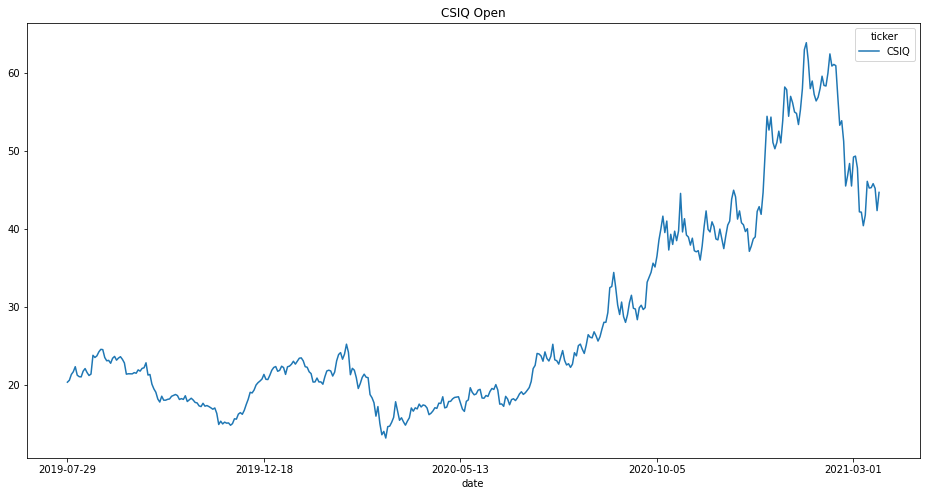

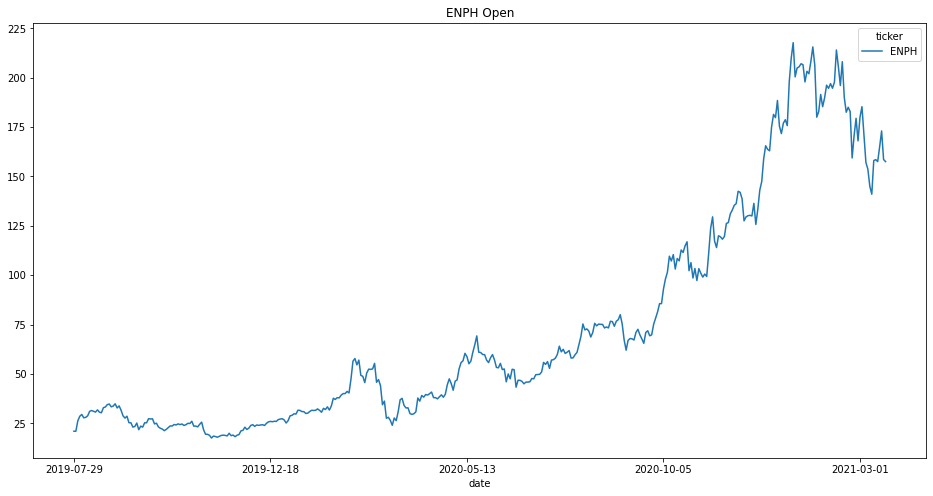

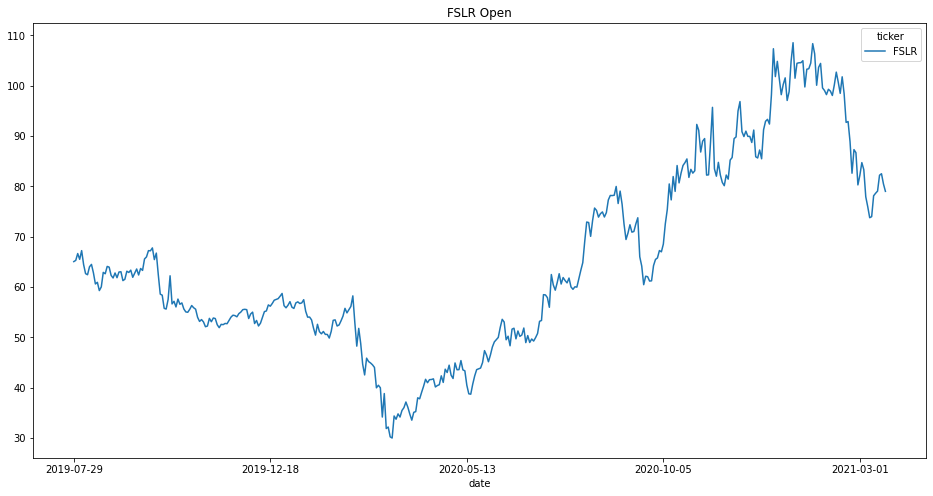

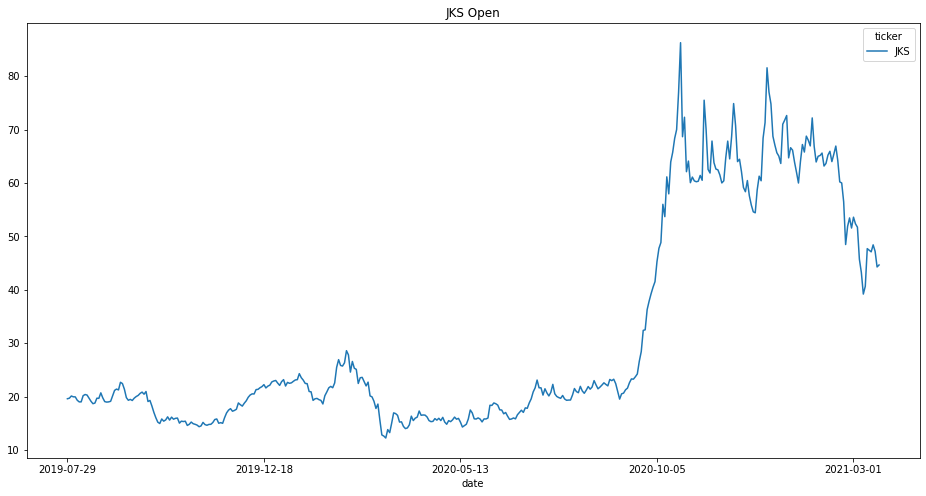

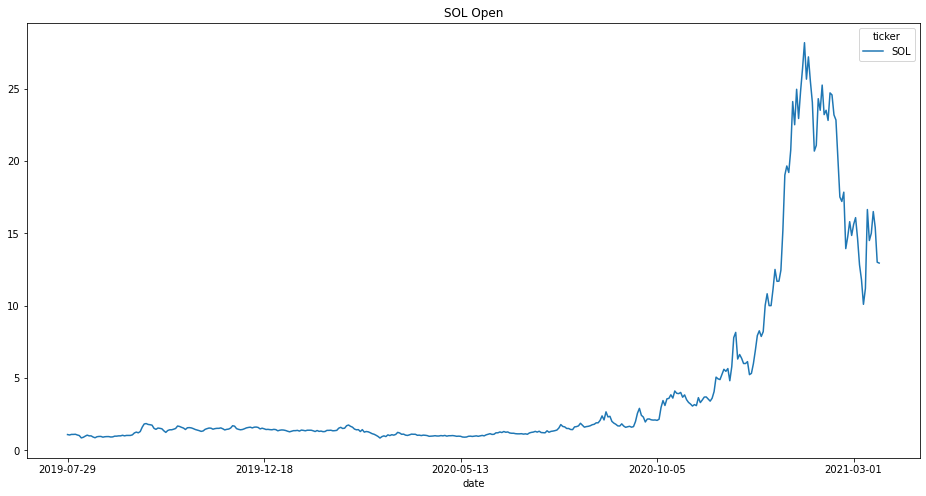

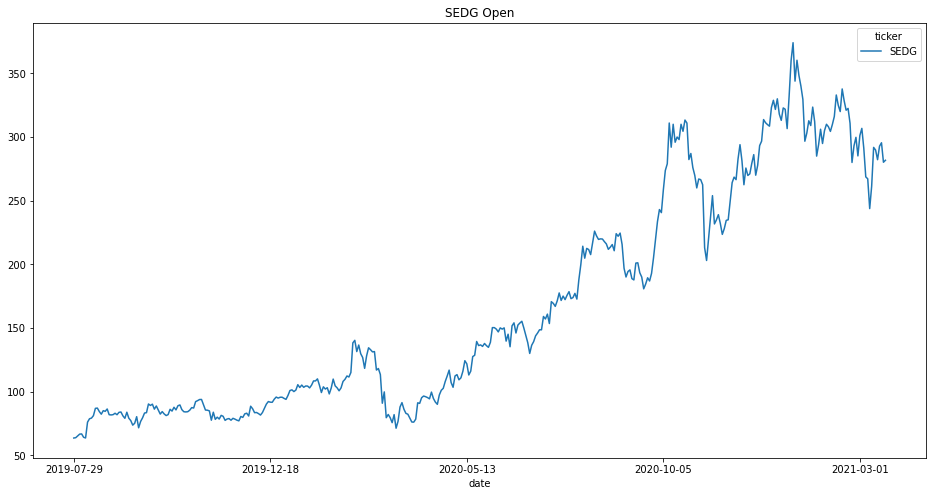

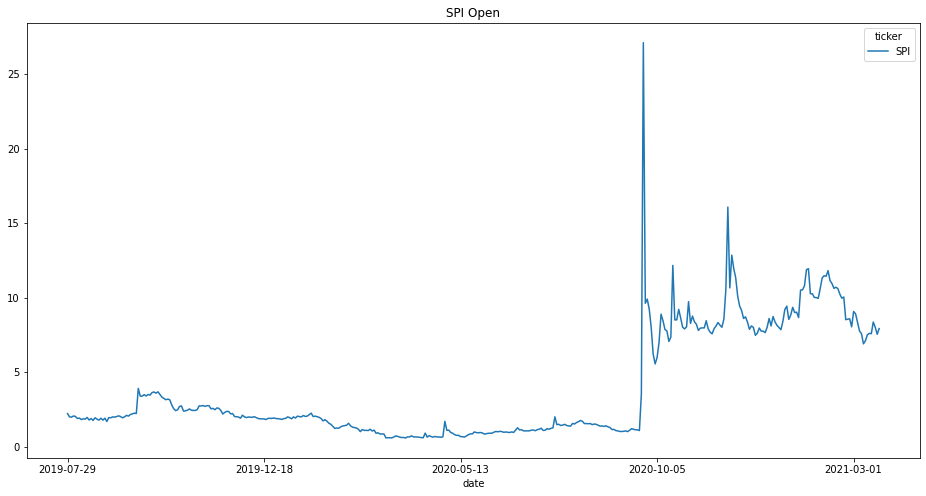

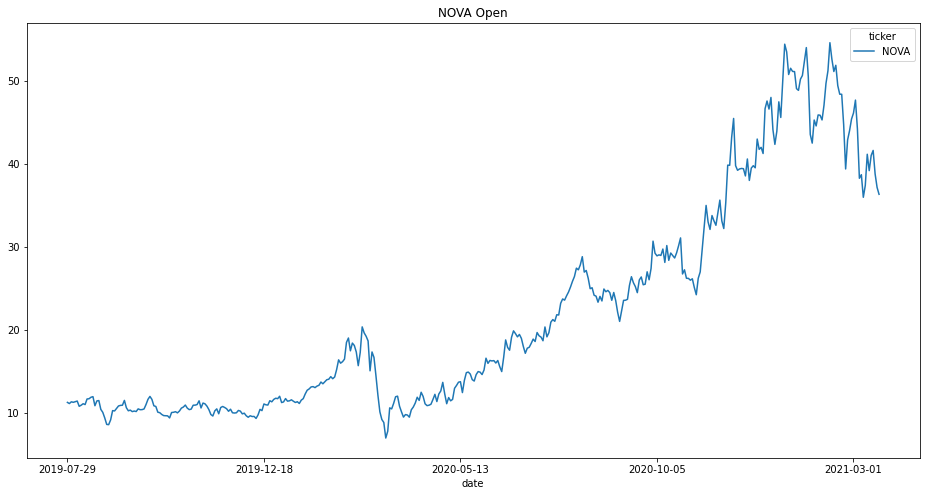

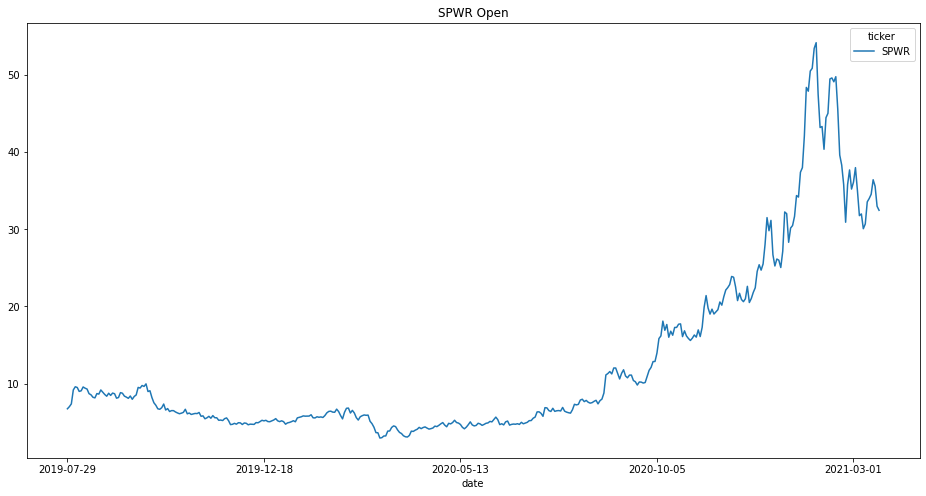

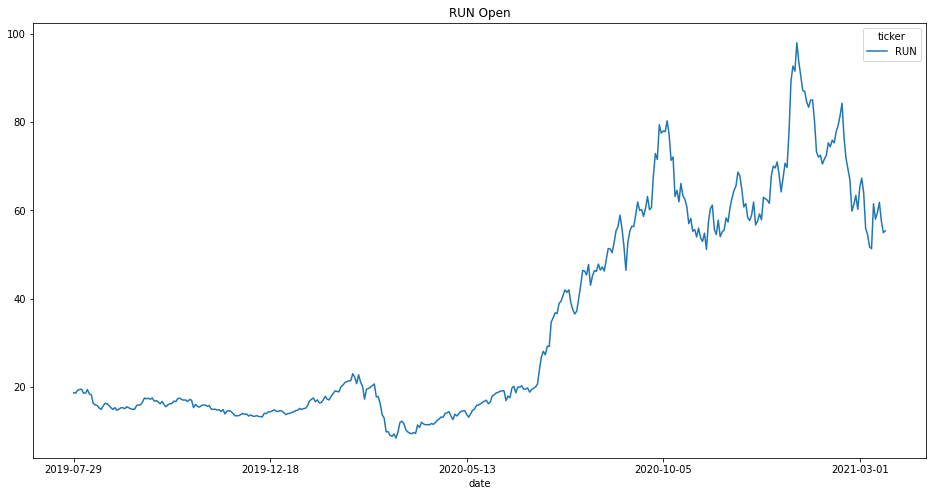

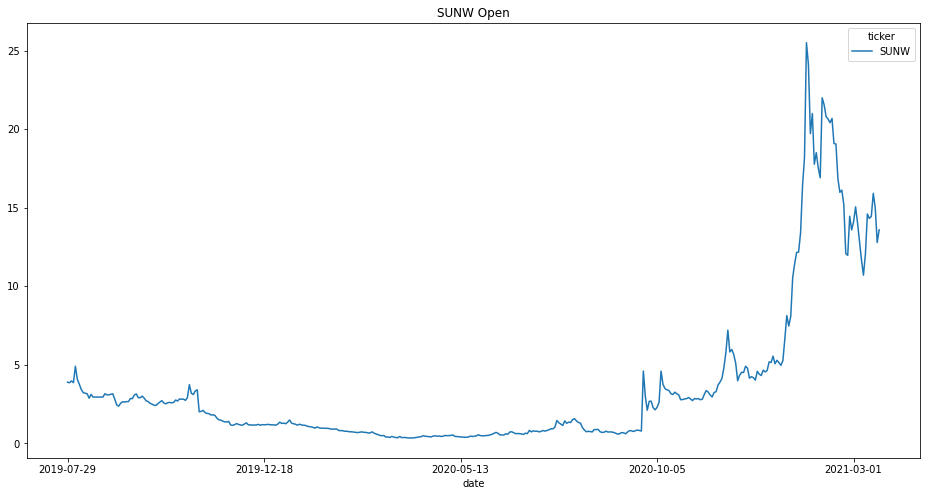

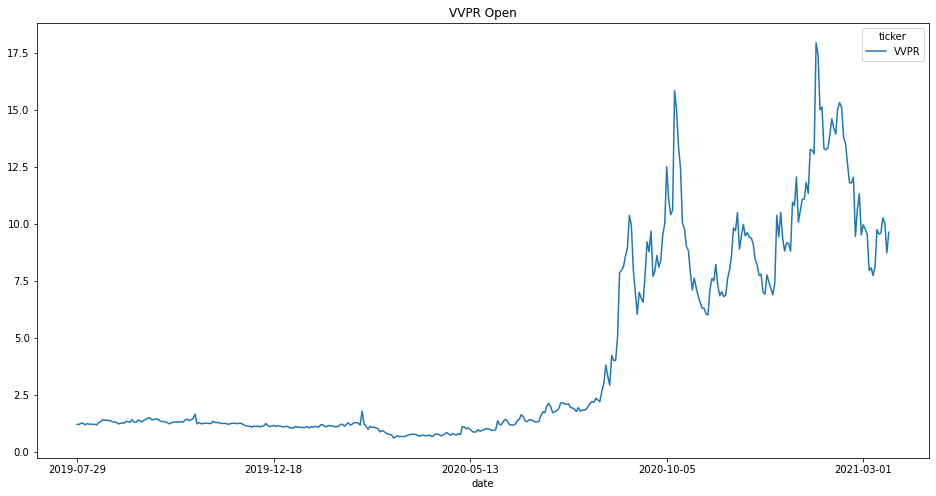

In [73]:
for ticker in tech_solar_price_df.index.get_level_values(0).unique():
    tech_solar_price_df.loc[[ticker]].reset_index().pivot(index="date", columns='ticker', values="open").plot(figsize=(16,8))
    plt.title(ticker + " Open")
    plt.show()

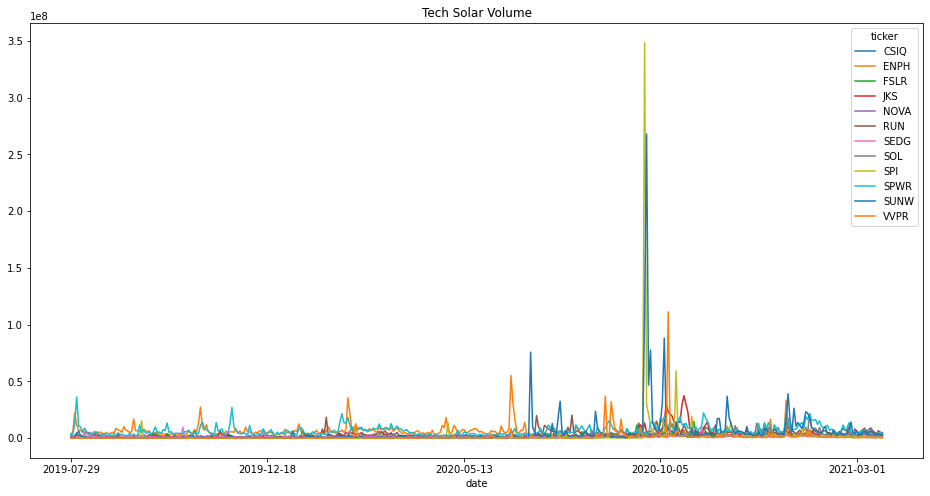

In [105]:
tech_solar_price_df.reset_index().pivot(index="date", columns='ticker', values="volume").plot(figsize=(16,8))
plt.title("Tech Solar Volume")
plt.show()

In [61]:
tech_solar_price_df

open       high        low   adjclose     volume
ticker date                                                             
CSIQ   2019-07-29  20.309999  20.780001  20.309999  20.719999   293800.0
       2019-07-30  20.559999  21.240000  20.370001  21.180000   510600.0
       2019-07-31  21.299999  21.690001  21.070000  21.320000   562100.0
       2019-08-01  21.650000  23.350000  21.650000  22.230000  1224600.0
       2019-08-02  22.299999  22.549999  21.549999  21.799999   507700.0
...                      ...        ...        ...        ...        ...
VVPR   2021-03-12   9.600000  10.300000   9.500000  10.220000   162600.0
       2021-03-15  10.260000  10.670000   9.880000   9.970000   348200.0
       2021-03-16  10.020000  10.241000   8.720000   9.090000   338300.0
       2021-03-17   8.730000   9.900000   8.730000   9.610000   188900.0
       2021-03-18   9.630000   9.669000   8.850000   8.950000   148300.0

[4968 rows x 5 columns]

# Aggiungiamo a ogni stock i suoi indicatori tecnici

In [51]:
def get_technical_indicators(dataset):
    #dataset.rename(columns={'GS': 'price'}, inplace=True)
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['adjclose'].rolling(window=7).mean()
    dataset['ma21'] = dataset['adjclose'].rolling(window=21).mean()
    
    # Create MACD 
    # Adjusted with udemy
    df_test = pd.DataFrame(data = np.array(dataset['adjclose']))
    dataset['26ema'] = df_test.ewm(span=26).mean()
    dataset['12ema'] = df_test.ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    # Adjusted with udemy
    dataset['20daymean'] = dataset['adjclose'].rolling(window=20).mean()
    dataset['upper_band'] = dataset['20daymean'] + 2*dataset['adjclose'].rolling(window=20).std()
    dataset['lower_band'] = dataset['20daymean'] - 2*dataset['adjclose'].rolling(window=20).std()
    
    # Create Exponential moving average
    dataset['ema'] = dataset['adjclose'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['adjclose']-1
    
    return dataset

In [93]:
for ticker in tech_solar_price_df.index.get_level_values(0).unique():
  technical_indicators_df = get_technical_indicators(tech_solar_price_df[['adjclose']].loc[slice(ticker), :])
  technical_indicators_df['log_momentum'] = np.log2(technical_indicators_df['momentum'])

In [94]:
technical_indicators_df.iloc[:, 1:]

ma7       ma21  ...   momentum  log_momentum
ticker date                             ...                         
CSIQ   2019-07-29       NaN        NaN  ...  19.719999      4.301588
       2019-07-30       NaN        NaN  ...  20.180000      4.334854
       2019-07-31       NaN        NaN  ...  20.320000      4.344828
       2019-08-01       NaN        NaN  ...  21.230000      4.408032
       2019-08-02       NaN        NaN  ...  20.799999      4.378512
...                     ...        ...  ...        ...           ...
VVPR   2021-03-12  8.890000  10.296905  ...   9.220000      3.204767
       2021-03-15  9.172857  10.109286  ...   8.970000      3.165108
       2021-03-16  9.382857   9.890238  ...   8.090000      3.016140
       2021-03-17  9.652857   9.745000  ...   8.610000      3.106013
       2021-03-18  9.604286   9.603571  ...   7.950000      2.990955

[4968 rows x 11 columns]

In [95]:
tech_solar_df = tech_solar_price_df.merge(technical_indicators_df.iloc[:, 1:], left_index=True, right_on=['ticker', 'date'])

In [101]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['adjclose'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

# Visualizziamo gli indicatori tecnici (da aggiustare MACD e Momentum)



----------------------- CSIQ -------------------




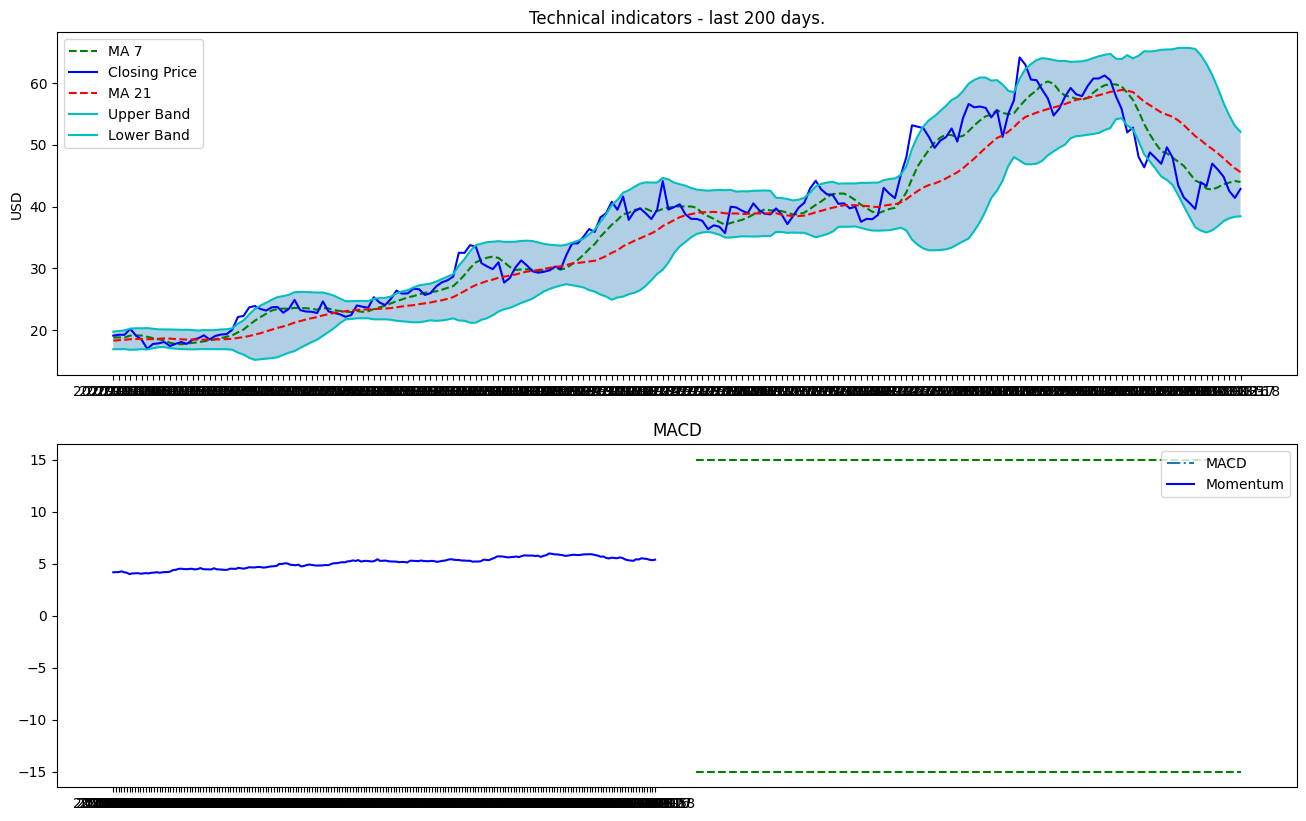



----------------------- ENPH -------------------




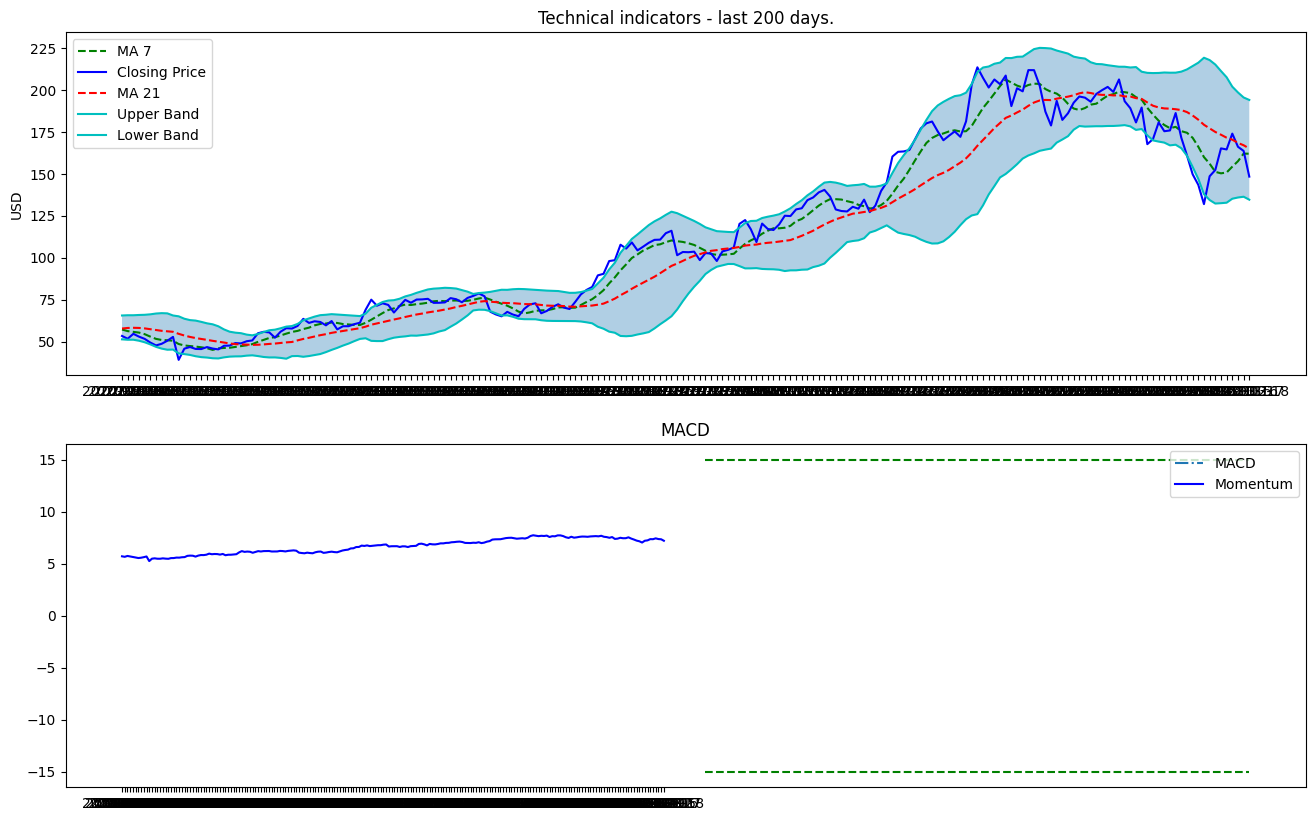



----------------------- FSLR -------------------




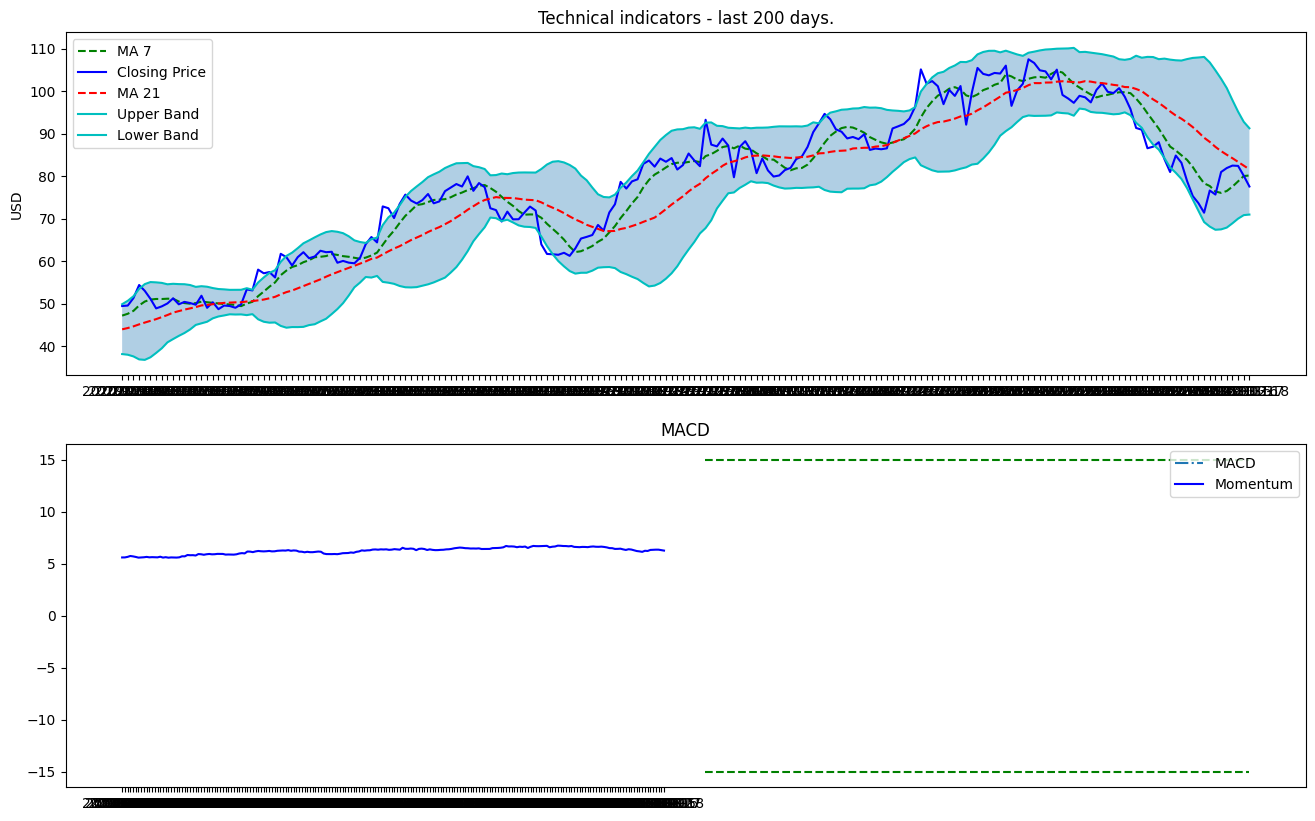



----------------------- JKS -------------------




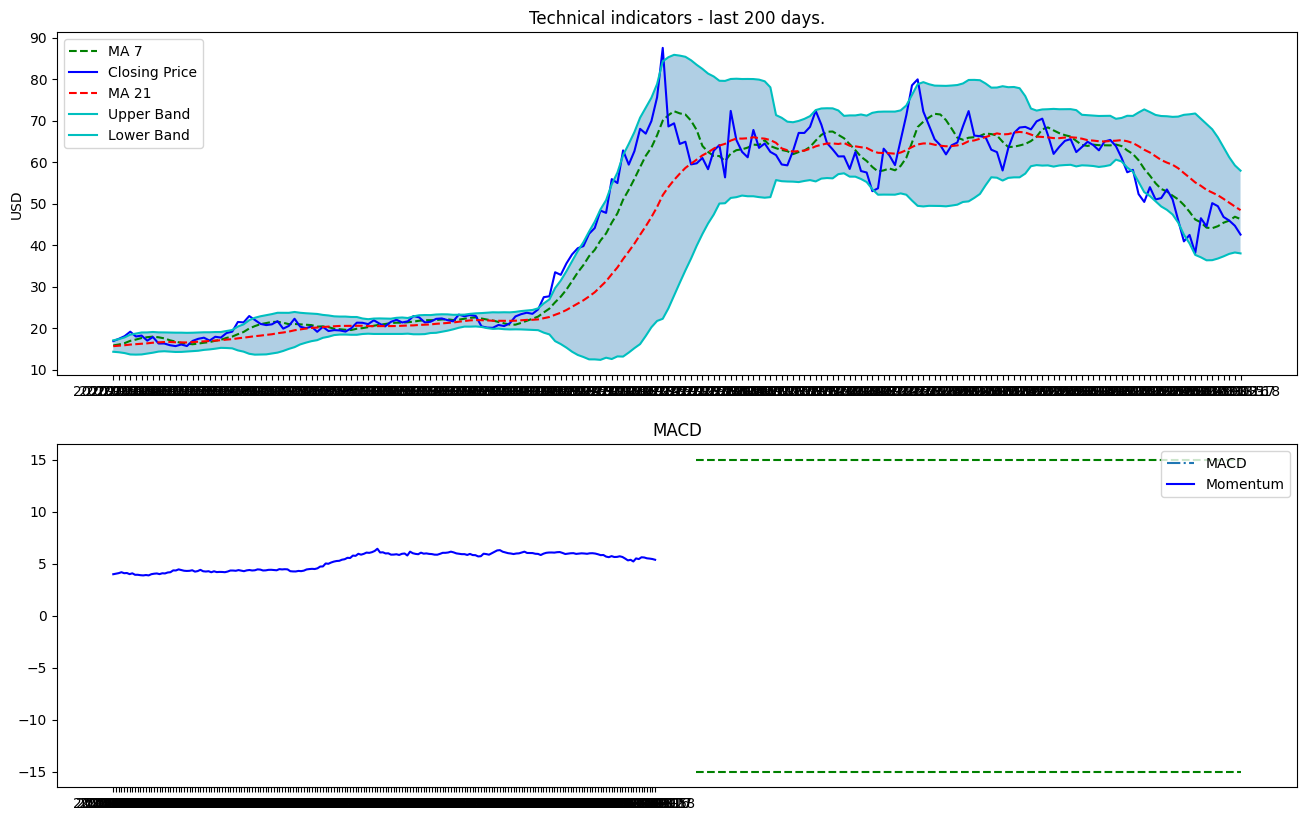



----------------------- SOL -------------------




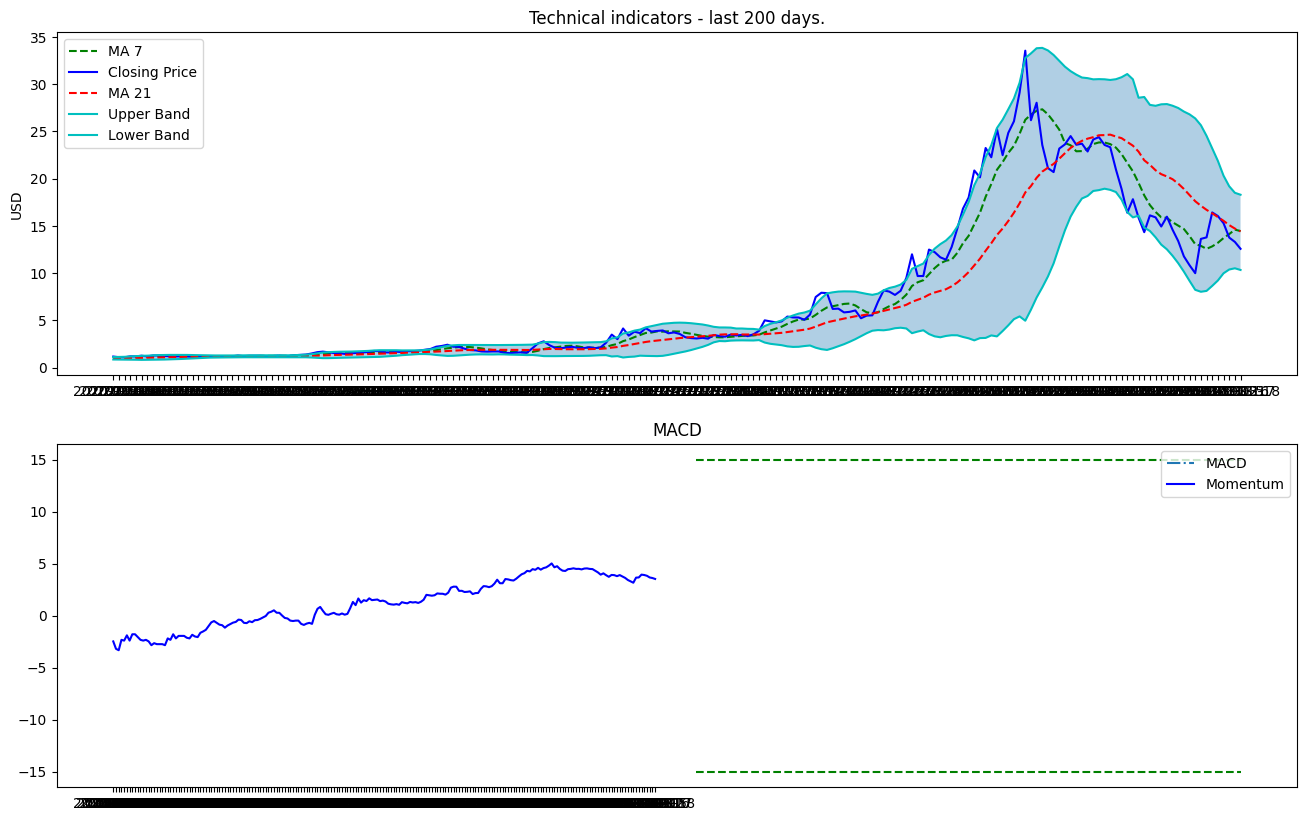



----------------------- SEDG -------------------




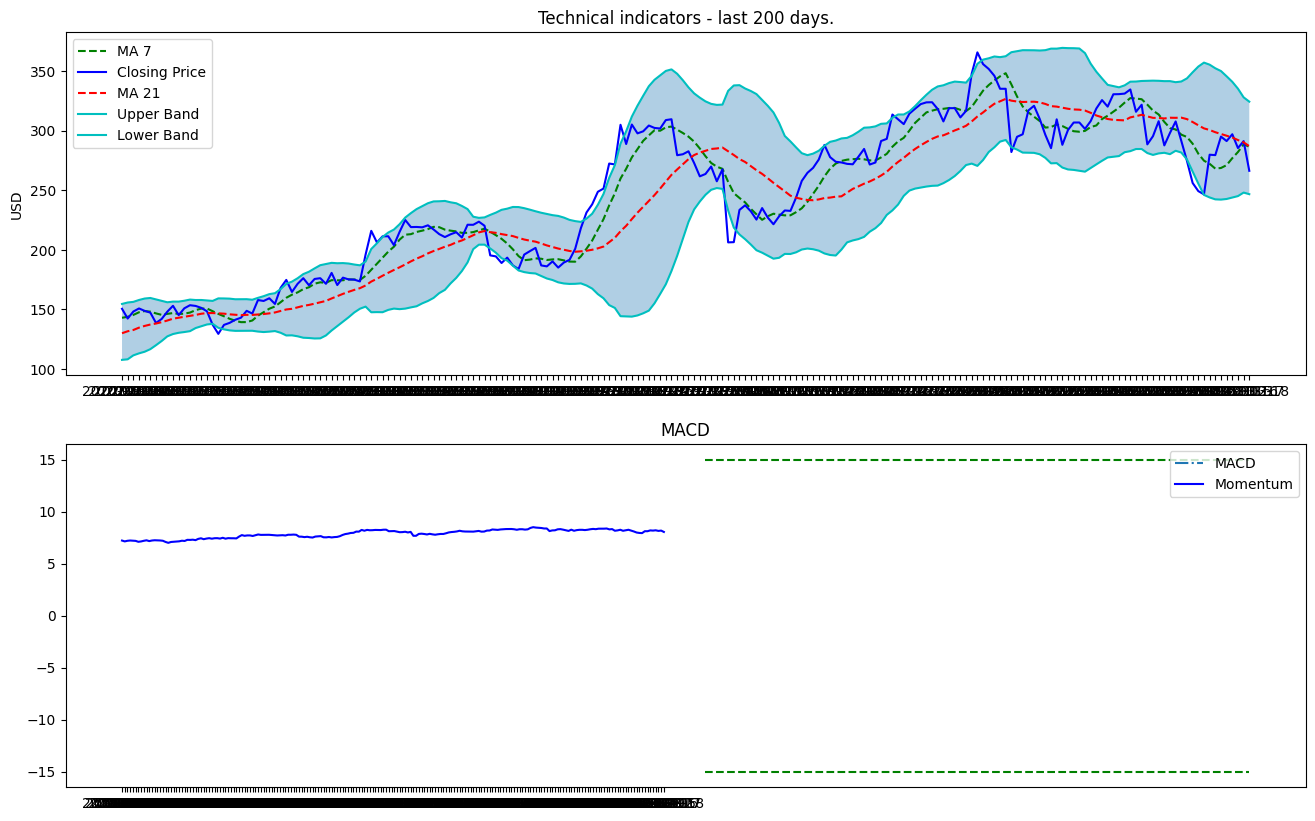



----------------------- SPI -------------------




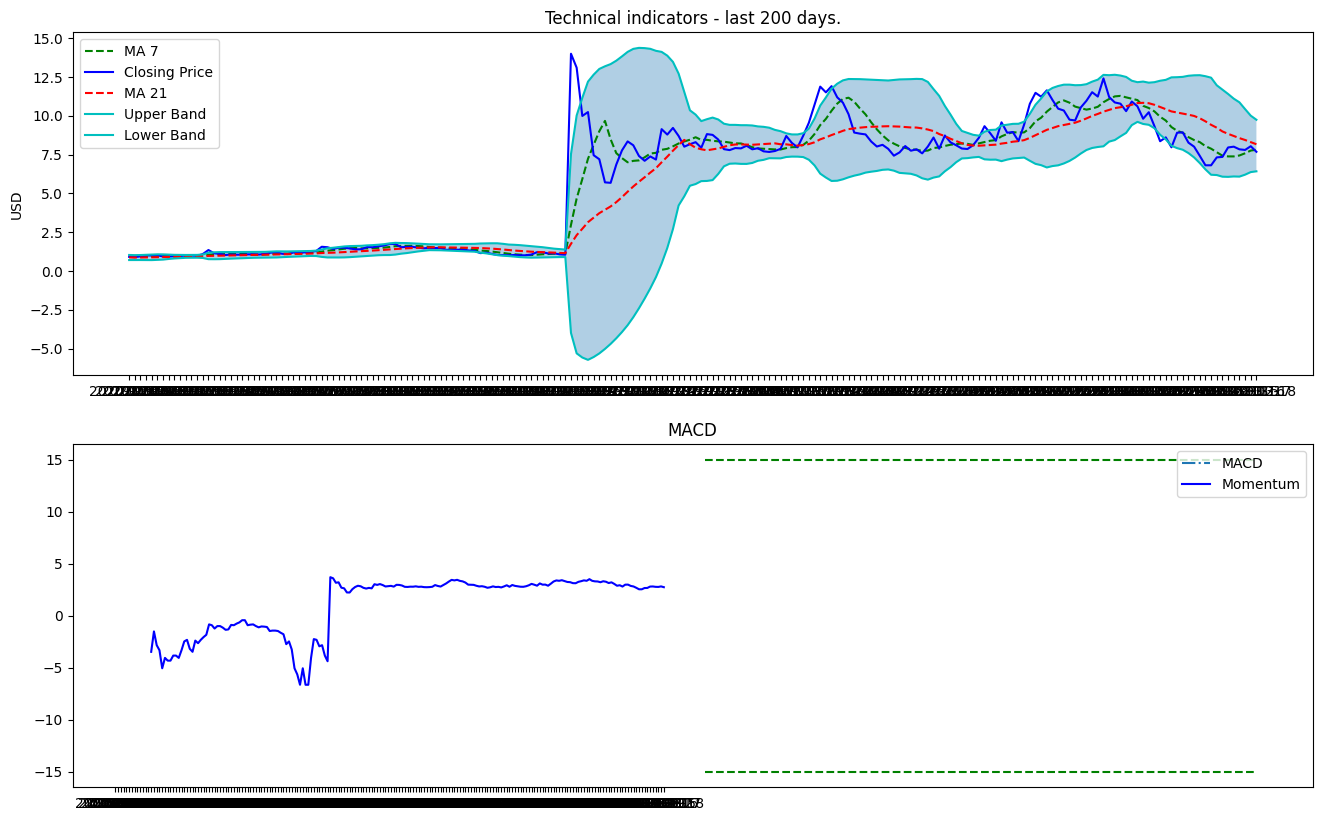



----------------------- NOVA -------------------




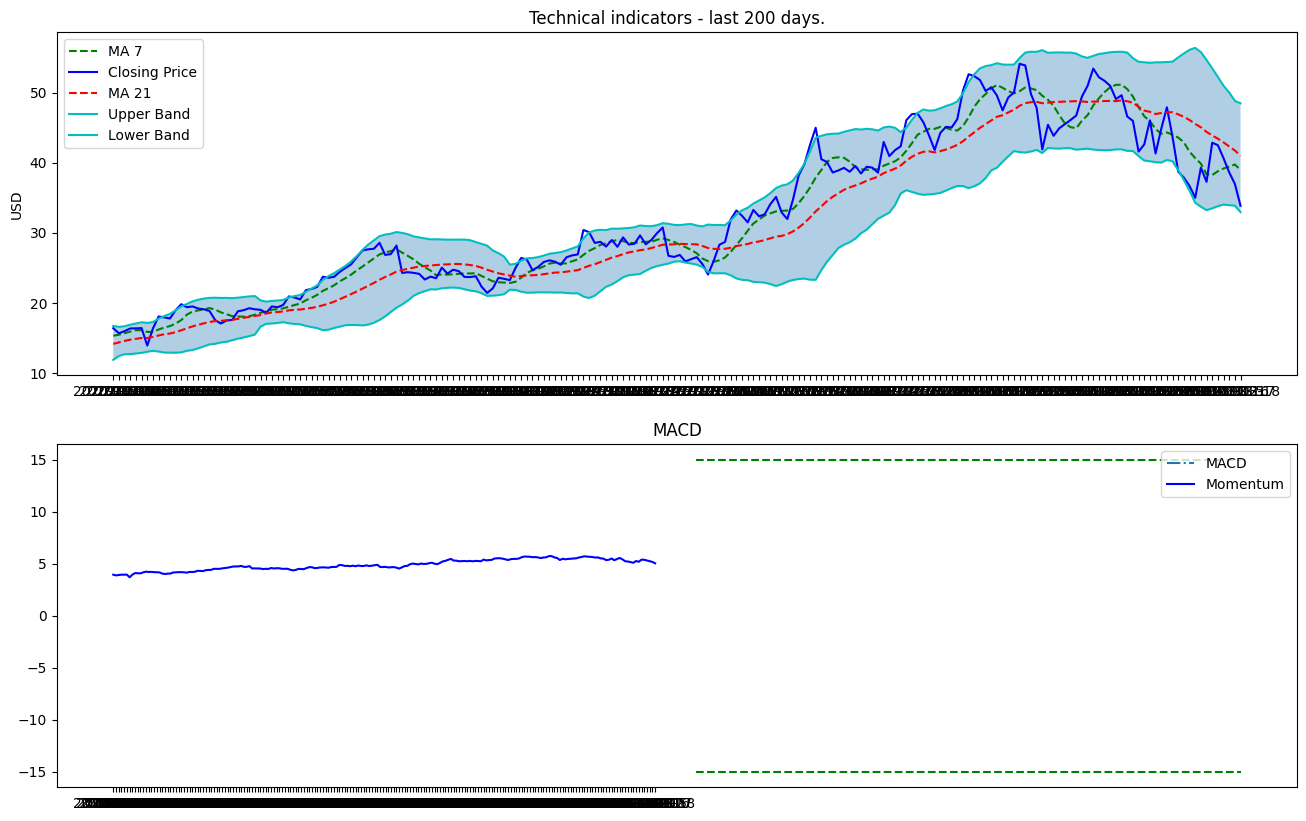



----------------------- SPWR -------------------




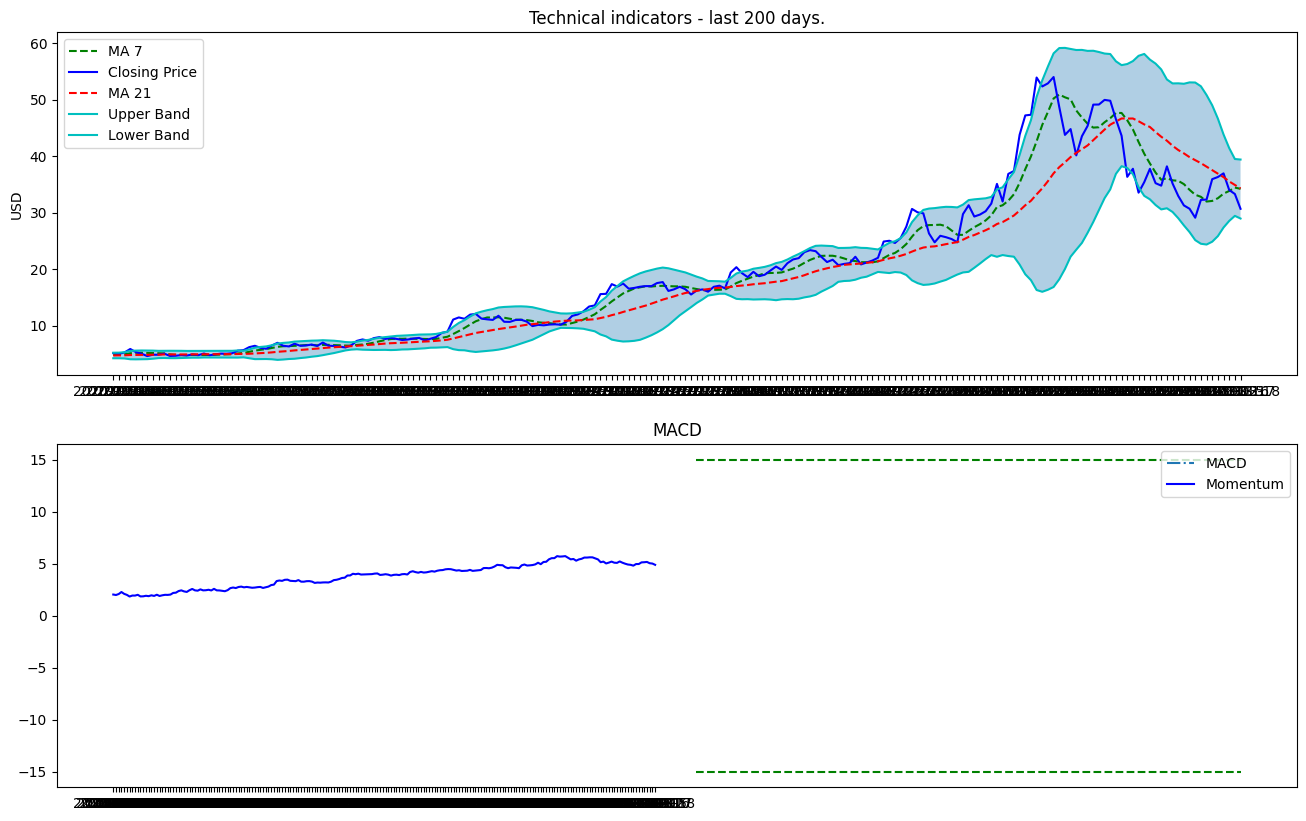



----------------------- RUN -------------------




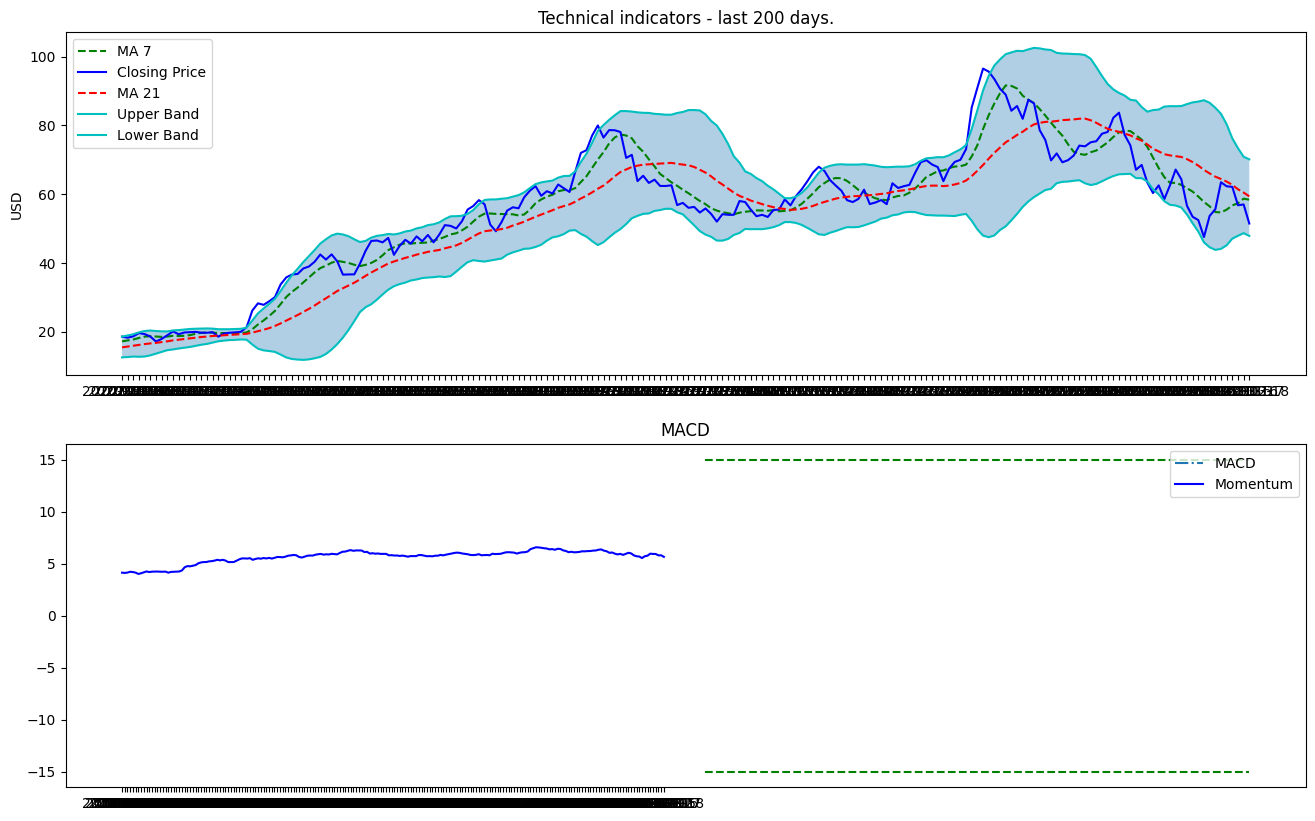



----------------------- SUNW -------------------




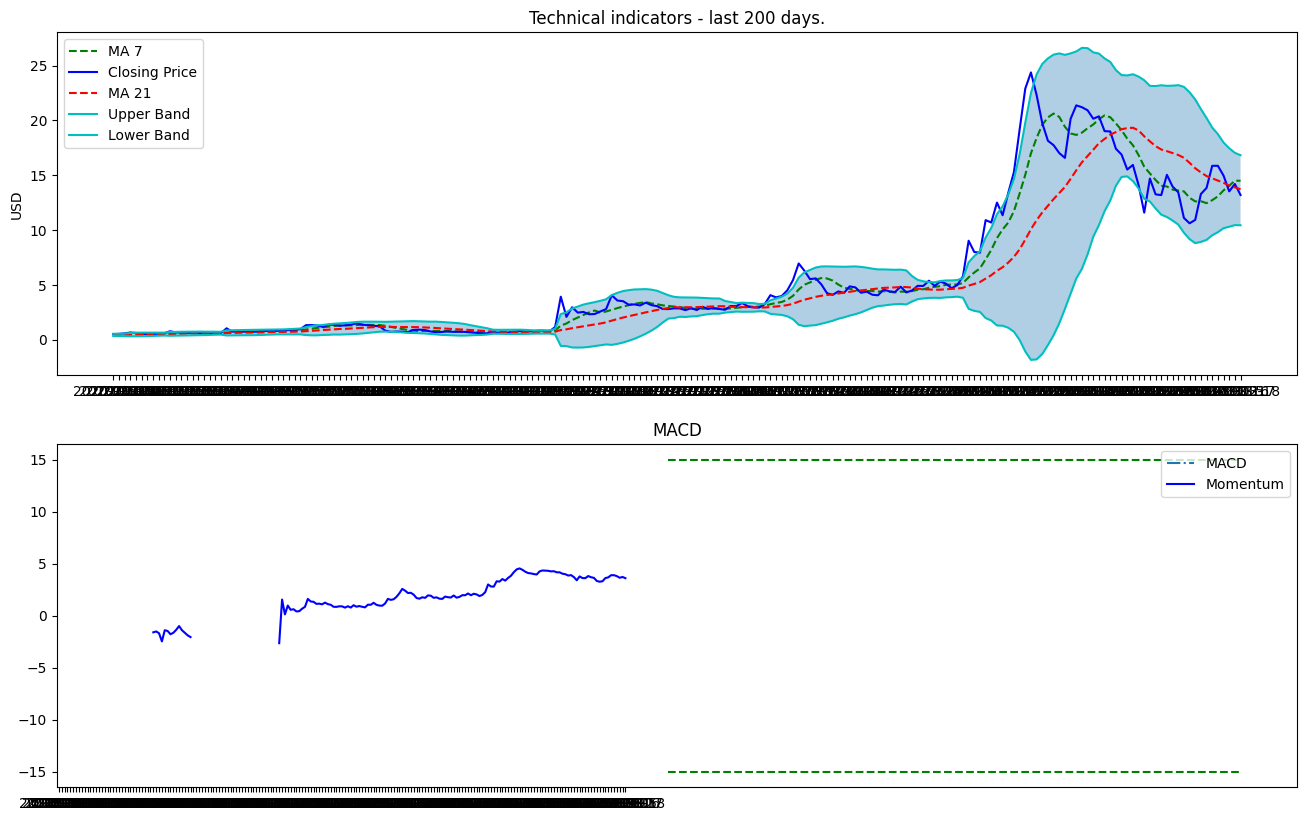



----------------------- VVPR -------------------




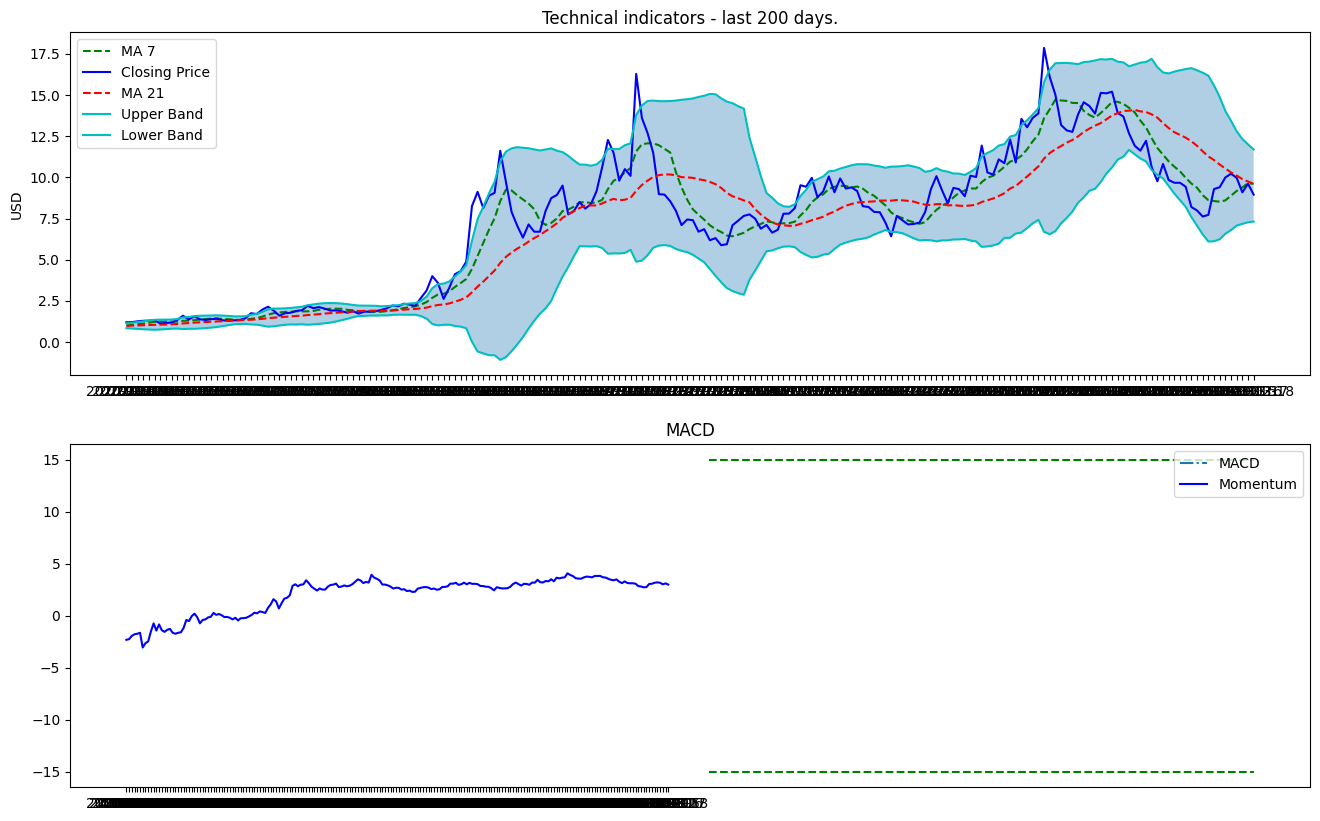

In [104]:
for ticker in tech_solar_df.index.get_level_values(0).unique():
  print('\n\n----------------------- '+ticker+' -------------------\n\n')
  plot_technical_indicators(tech_solar_df.loc[[ticker]].droplevel(level=0), 200)


### AdjClose relative variance + High-Low varicane + Countdown indicator 
(https://medium.com/geekculture/the-countdown-indicator-a-new-tool-in-contrarian-trading-3648a5c20d5)

In [122]:
tech_solar_df[['adjclose_rel_var']] = (tech_solar_df[['adjclose']].values-tech_solar_df[['open']].values)/tech_solar_df[['open']].values
tech_solar_df[['high_low_var']] = tech_solar_df[['high']].values-tech_solar_df[['low']].values

In [126]:
tech_solar_df.describe()

,open,high,low,adjclose,volume,ma7,ma21,26ema,12ema,MACD,20daymean,upper_band,lower_band,ema,momentum,log_momentum,adjclose_rel_var,high_low_var
count,4968.000000,4968.000000,4968.000000,4968.000000,4.968000e+03,4962.000000,4948.000000,0.0,0.0,0.0,4949.000000,4949.000000,4949.000000,4968.000000,4968.000000,4657.000000,4968.000000,4968.000000
mean,37.377954,38.585812,36.126548,37.352376,2.755405e+06,37.378979,37.440771,NaN,NaN,NaN,37.436485,45.644611,29.228358,37.353556,36.352376,-inf,0.001320,2.459264
std,55.499188,57.100214,53.693492,55.403538,7.787587e+06,55.122273,54.548926,NaN,NaN,NaN,54.590814,66.642419,47.111999,55.304793,55.403538,NaN,0.070761,3.963839
min,0.331000,0.340000,0.290000,0.325000,7.000000e+02,0.346143,0.379048,NaN,NaN,NaN,0.375700,0.446435,-181.448964,0.328150,-0.675000,-inf,-0.516605,0.010000
25%,4.007500,4.279681,3.850004,4.093337,5.140500e+05,4.265366,4.598749,NaN,NaN,NaN,4.583000,5.499447,2.207429,4.240941,3.093337,2.438293,-0.027769,0.307793
50%,17.455000,18.059999,16.820000,17.410000,1.338750e+06,17.592857,17.653572,NaN,NaN,NaN,17.612500,21.305635,13.914818,17.376061,16.410000,4.172328,0.000000,1.040000
75%,50.767499,52.262500,49.162501,50.650000,3.245900e+06,50.620358,49.914167,NaN,NaN,NaN,49.965100,59.633153,38.959884,50.730896,49.650000,5.707083,0.025211,3.000000
max,374.100006,377.000000,350.440002,365.970001,3.483018e+08,348.479994,326.905712,NaN,NaN,NaN,327.562498,460.906195,292.399942,356.427263,364.970001,8.511634,2.954802,49.100006


In [ ]:
from sklearn import preprocessing

In [ ]:
# standardization
preprocessing.scale(high_low_var)

In [ ]:
# possiamo procedere con lo scaling tramite scikit-learn:
high_low_var_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
high_low_var_scaled = high_low_var_scaler.fit_transform(high_low_var)
high_low_var_scaled

In [ ]:
df = pd.DataFrame(data=high_low_var_scaled, index=high_low_var.index, columns=high_low_var.columns)
df